## CERES TOA data

Playing around with the CERES EBAF-TOA Ed4.0 net TOA all-sky radiative flux data downloaded from [here](https://ceres-tool.larc.nasa.gov/ord-tool/jsp/EBAF4Selection.jsp).

In [1]:
import re
import glob
import numpy
import matplotlib.pyplot as plt
import iris
import iris.coord_categorisation
from iris.experimental.equalise_cubes import equalise_attributes
import iris.plot as iplt
import warnings
warnings.filterwarnings('ignore')

/g/data/r87/dbi599/miniconda3/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/g/data/r87/dbi599/miniconda3/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:
%matplotlib inline

In [3]:
infile = '/g/data/r87/dbi599/data_ceres/CERES_EBAF-TOA_Ed4.0_Subset_200003-201312.nc'

In [4]:
cube = iris.load(infile)[0]
cube

<iris 'Cube' of Top of The Atmosphere Net Flux, Monthly Means, All-Sky conditions / (W m-2) (time: 166; latitude: 180; longitude: 360)>

In [5]:
cube.coord('time').guess_bounds()

In [6]:
print(cube.coord('time'))

DimCoord([2000-03-15 00:00:00, 2000-04-15 00:00:00, 2000-05-15 00:00:00,
       2000-06-15 00:00:00, 2000-07-15 00:00:00, 2000-08-15 00:00:00,
       2000-09-15 00:00:00, 2000-10-15 00:00:00, 2000-11-15 00:00:00,
       2000-12-15 00:00:00, 2001-01-15 00:00:00, 2001-02-15 00:00:00,
       2001-03-15 00:00:00, 2001-04-15 00:00:00, 2001-05-15 00:00:00,
       2001-06-15 00:00:00, 2001-07-15 00:00:00, 2001-08-15 00:00:00,
       2001-09-15 00:00:00, 2001-10-15 00:00:00, 2001-11-15 00:00:00,
       2001-12-15 00:00:00, 2002-01-15 00:00:00, 2002-02-15 00:00:00,
       2002-03-15 00:00:00, 2002-04-15 00:00:00, 2002-05-15 00:00:00,
       2002-06-15 00:00:00, 2002-07-15 00:00:00, 2002-08-15 00:00:00,
       2002-09-15 00:00:00, 2002-10-15 00:00:00, 2002-11-15 00:00:00,
       2002-12-15 00:00:00, 2003-01-15 00:00:00, 2003-02-15 00:00:00,
       2003-03-15 00:00:00, 2003-04-15 00:00:00, 2003-05-15 00:00:00,
       2003-06-15 00:00:00, 2003-07-15 00:00:00, 2003-08-15 00:00:00,
       2003-09-15

In [7]:
cube.coord('time')

DimCoord(array([  14,   45,   75,  106,  136,  167,  198,  228,  259,  289,  320,
        351,  379,  410,  440,  471,  501,  532,  563,  593,  624,  654,
        685,  716,  744,  775,  805,  836,  866,  897,  928,  958,  989,
       1019, 1050, 1081, 1109, 1140, 1170, 1201, 1231, 1262, 1293, 1323,
       1354, 1384, 1415, 1446, 1475, 1506, 1536, 1567, 1597, 1628, 1659,
       1689, 1720, 1750, 1781, 1812, 1840, 1871, 1901, 1932, 1962, 1993,
       2024, 2054, 2085, 2115, 2146, 2177, 2205, 2236, 2266, 2297, 2327,
       2358, 2389, 2419, 2450, 2480, 2511, 2542, 2570, 2601, 2631, 2662,
       2692, 2723, 2754, 2784, 2815, 2845, 2876, 2907, 2936, 2967, 2997,
       3028, 3058, 3089, 3120, 3150, 3181, 3211, 3242, 3273, 3301, 3332,
       3362, 3393, 3423, 3454, 3485, 3515, 3546, 3576, 3607, 3638, 3666,
       3697, 3727, 3758, 3788, 3819, 3850, 3880, 3911, 3941, 3972, 4003,
       4031, 4062, 4092, 4123, 4153, 4184, 4215, 4245, 4276, 4306, 4337,
       4368, 4397, 4428, 4458, 4489, 4519,

In [8]:
def broadcast_array(array, axis_index, shape):
    """Broadcast an array to a target shape.
    
    Args:
      array (numpy.ndarray)
      axis_index (int or tuple): Postion in the target shape that the 
        axis/axes of the array corresponds to
          e.g. if array corresponds to (depth, lat, lon) in (time, depth, lat, lon)
          then axis_index = [1, 3]
          e.g. if array corresponds to (lat) in (time, depth, lat, lon)
          then axis_index = 2
      shape (tuple): shape to broadcast to
      
    For a one dimensional array, make start_axis_index = end_axis_index
    
    """

    if type(axis_index) in [float, int]:
        start_axis_index = end_axis_index = axis_index
    else:
        assert len(axis_index) == 2
        start_axis_index, end_axis_index = axis_index
    
    dim = start_axis_index - 1
    while dim >= 0:
        array = array[numpy.newaxis, ...]
        array = numpy.repeat(array, shape[dim], axis=0)
        dim = dim - 1
    
    dim = end_axis_index + 1
    while dim < len(shape):    
        array = array[..., numpy.newaxis]
        array = numpy.repeat(array, shape[dim], axis=-1)
        dim = dim + 1

    return array


def convert_to_joules(cube):
    """Convert units from Watts to Joules"""
    
    assert 'W' in str(cube.units)
    
    time_span_days = cube.coord('time').bounds[:, 1] - cube.coord('time').bounds[:, 0]
    time_span_seconds = time_span_days * 60 * 60 * 24
    
    cube.data = cube.data * broadcast_array(time_span_seconds, 0, cube.shape)
    cube.units = str(cube.units).replace('W', 'J')
    
    return cube


def convert_to_annual(cube, full_months=False):
    """Convert data to annual timescale.
    Args:
      cube (iris.cube.Cube)
      full_months(bool): only include years with data for all 12 months
    """

    iris.coord_categorisation.add_year(cube, 'time')
    iris.coord_categorisation.add_month(cube, 'time')

    cube = cube.aggregated_by(['year'], iris.analysis.SUM)
    if full_months:
        cube = cube.extract(iris.Constraint(month='Jan|Feb|Mar|Apr|May|Jun|Jul|Aug|Sep|Oct|Nov|Dec'))
  
    cube.remove_coord('year')
    cube.remove_coord('month')

    return cube


def remove_m2(cube):
    """Multipy a cube by its area."""

    if not cube.coord('latitude').has_bounds():
        cube.coord('latitude').guess_bounds()
    if not cube.coord('longitude').has_bounds():
        cube.coord('longitude').guess_bounds()
    area_weights = iris.analysis.cartography.area_weights(cube)

    cube.data = cube.data * area_weights
    cube.units = str(cube.units).replace('m-2', '')
    
    return cube


def extract_region(cube, lat_bounds):
    """Extract region of interest from a regular lat/lon grid.
    
    Returns subset of the original cube that contains only the latitude range of interest. 
    """

    southern_lat, northern_lat = lat_bounds
    lat_constraint = iris.Constraint(latitude=lambda cell: southern_lat <= cell < northern_lat)
    cube = cube.extract(lat_constraint)

    return cube


def spatial_sum(cube, lat_bounds=None):
    """Calculate the spatial sum"""
    
    cube = cube.copy()
    
    if lat_bounds:
        cube = extract_region(cube, lat_bounds)
    
    cube = cube.collapsed(['latitude', 'longitude'], iris.analysis.SUM)
    cube.remove_coord('latitude')
    cube.remove_coord('longitude')
    
    return cube


def cumsum(cube):
    """Calculate the cumulative sum."""

    cube = cube.copy()
    
    cube.data = numpy.cumsum(cube.data, axis=0)
    
    return cube


def calc_anomaly(cube):
    """Calculate the anomaly."""
    
    anomaly = cube.copy()
    anomaly.data = anomaly.data - anomaly.data[0]
    
    return anomaly


In [9]:
cube = remove_m2(cube)
cube

<iris 'Cube' of Top of The Atmosphere Net Flux, Monthly Means, All-Sky conditions / (W) (time: 166; latitude: 180; longitude: 360)>

In [10]:
cube = convert_to_joules(cube)
cube

<iris 'Cube' of Top of The Atmosphere Net Flux, Monthly Means, All-Sky conditions / (J) (time: 166; latitude: 180; longitude: 360)>

In [11]:
cube = convert_to_annual(cube, full_months=True)
cube

<iris 'Cube' of Top of The Atmosphere Net Flux, Monthly Means, All-Sky conditions / (J) (time: 13; latitude: 180; longitude: 360)>

In [12]:
print(cube.coord('time'))

DimCoord([2001-07-01 00:00:00, 2002-07-01 00:00:00, 2003-07-01 00:00:00,
       2004-06-30 12:00:00, 2005-07-01 00:00:00, 2006-07-01 00:00:00,
       2007-07-01 00:00:00, 2008-06-30 12:00:00, 2009-07-01 00:00:00,
       2010-07-01 00:00:00, 2011-07-01 00:00:00, 2012-06-30 12:00:00,
       2013-06-30 18:00:00], bounds=[[2000-12-30 12:00:00, 2001-12-30 12:00:00],
       [2001-12-30 12:00:00, 2002-12-30 12:00:00],
       [2002-12-30 12:00:00, 2003-12-30 12:00:00],
       [2003-12-30 12:00:00, 2004-12-30 12:00:00],
       [2004-12-30 12:00:00, 2005-12-30 12:00:00],
       [2005-12-30 12:00:00, 2006-12-30 12:00:00],
       [2006-12-30 12:00:00, 2007-12-30 12:00:00],
       [2007-12-30 12:00:00, 2008-12-30 12:00:00],
       [2008-12-30 12:00:00, 2009-12-30 12:00:00],
       [2009-12-30 12:00:00, 2010-12-30 12:00:00],
       [2010-12-30 12:00:00, 2011-12-30 12:00:00],
       [2011-12-30 12:00:00, 2012-12-30 12:00:00],
       [2012-12-30 12:00:00, 2013-12-30 00:00:00]], standard_name='time', c

In [13]:
global_sum = spatial_sum(cube)
nh_sum = spatial_sum(cube, lat_bounds=[0, 90])
sh_sum = spatial_sum(cube, lat_bounds=[-90, 0])

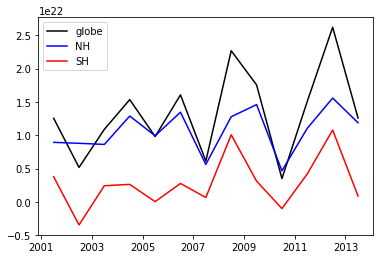

In [14]:
iplt.plot(global_sum, color='black', label='globe')
iplt.plot(nh_sum, color='blue', label='NH')
iplt.plot(sh_sum, 'red', label='SH')
plt.legend()
plt.show()

A cumulative sum is easy to calculate for the globe, because the equilibrium/stationary climate value is zero:

In [15]:
global_cumsum = cumsum(global_sum)
global_cumsum = calc_anomaly(global_cumsum)

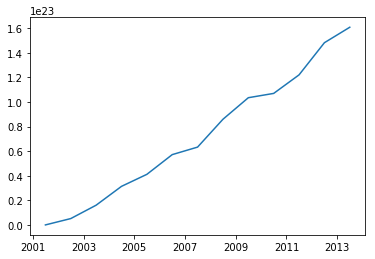

In [16]:
iplt.plot(global_cumsum)
plt.show()

The same is not true for each hemisphere - in a stationary climate one hemisphere might lose heat and the other gain.

For a long and/or not noisy hemispheric timeseries, you could just use the first data point as the stationary climate value (i.e. and calculate the anomaly timeseries relative to that point before calculating the cumulative sum), but clearly the 13-year CERES record is too noisy for that.

Instead, it's probably best to apply a linear line of best fit to compare the two hemispheres...

In [17]:
def linear_trend(cube):
    """Return the linear trend line"""
    
    trend = cube.copy()
    x = cube.coord('time').points
    y = cube.data
    z = numpy.polyfit(x, y, 1)
    p = numpy.poly1d(z)
    
    # the line equation:
    print('y=%.6fx+(%.6f)' %(z[0],z[1]))
    
    trend.data = p(x)
    
    return trend

In [18]:
global_trend = linear_trend(global_sum)
nh_trend = linear_trend(nh_sum)
sh_trend = linear_trend(sh_sum)

y=1637062588171799296.000000x+(8956707502956566544384.000000)
y=681589430777889792.000000x+(8840252450748077441024.000000)
y=955135500867678592.000000x+(271775120126585438208.000000)


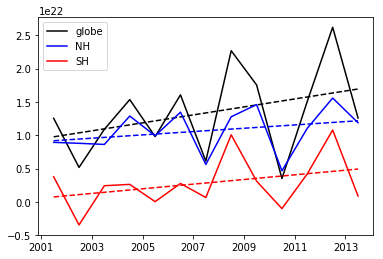

In [19]:
iplt.plot(global_sum, color='black', label='globe')
iplt.plot(global_trend, color='black', linestyle='--')

iplt.plot(nh_sum, color='blue', label='NH')
iplt.plot(nh_trend, color='blue', linestyle='--')

iplt.plot(sh_sum, 'red', label='SH')
iplt.plot(sh_trend, 'red', linestyle='--')

plt.legend()
plt.show()

## Model data

In [41]:
def get_time_constraint(time_list):
    """Get the time constraint used for reading an iris cube."""
    
    if time_list:

        start_date, end_date = time_list

        date_pattern = '([0-9]{4})-([0-9]{1,2})-([0-9]{1,2})'
        assert re.search(date_pattern, start_date)
        assert re.search(date_pattern, end_date)

        if (start_date == end_date):
            year, month, day = start_date.split('-')    
            time_constraint = iris.Constraint(time=iris.time.PartialDateTime(year=int(year), month=int(month), day=int(day)))
        else:  
            start_year, start_month, start_day = start_date.split('-') 
            end_year, end_month, end_day = end_date.split('-')
            time_constraint = iris.Constraint(time=lambda t: iris.time.PartialDateTime(year=int(start_year), month=int(start_month), day=int(start_day)) <= t.point <= iris.time.PartialDateTime(year=int(end_year), month=int(end_month), day=int(end_day)))
    else:
        time_constraint = iris.Constraint()

    return time_constraint


def get_data_triplet(model, experiment, ensnum):
    """Get a data triplet of interest"""

    time_constraint = get_time_constraint(['1861-01-01', '2005-12-31'])    
    dir_experiment = 'rcp85' if experiment == 'historical-rcp85' else experiment 

    mydir = '/g/data/r87/dbi599/DRSv2/CMIP5/%s/%s/yr/atmos/r1i1p1/rndt/latest/dedrifted'  %(model, dir_experiment)
 
    output = {}
    for region in ['sh', 'nh', 'globe']:
        file_start = 'rndt-%s-sum'  %(region)
        files = glob.glob('%s/%s_*_all.nc' %(mydir, file_start))
        assert len(files) == 1, '%s/%s_*_all.nc' %(mydir, file_start)
                
        var_name = 'TOA Incoming Net Radiation %s sum'  %(region)
        print(files[0], var_name)
        cube = iris.load_cube(files[0], var_name)   # & time_constraint

        new_aux_coord = iris.coords.AuxCoord(ensnum, long_name='ensemble_member', units='no_unit')
        cube.add_aux_coord(new_aux_coord)
        cube.cell_methods = ()
        
        output[region] = cube
   
    return output['sh'], output['nh'], output['globe']


def equalise_time_axes(cube_list):
    """Make all the time axes the same."""

    iris.util.unify_time_units(cube_list)
    reference_cube = cube_list[0]
    new_cube_list = iris.cube.CubeList([])
    for cube in cube_list:
        assert len(cube.coord('time').points) == len(reference_cube.coord('time').points)
        cube.coord('time').points = reference_cube.coord('time').points
        cube.coord('time').bounds = reference_cube.coord('time').bounds
        cube.coord('time').units = reference_cube.coord('time').units
        cube.coord('time').attributes = reference_cube.coord('time').attributes
        new_cube_list.append(cube)
    
    return new_cube_list


def ensemble_aggregation(cube_list, operator):
    """Calculate the ensemble mean."""

    aggregators = {'mean': iris.analysis.MEAN, 'median': iris.analysis.MEDIAN}

    if len(cube_list) > 1:
        equalise_attributes(cube_list)
        equalise_time_axes(cube_list)
        ensemble_cube = cube_list.merge_cube()
        ensemble_agg = ensemble_cube.collapsed('ensemble_member', aggregators[operator])
        ensemble_spread = ensemble_cube.collapsed('ensemble_member', iris.analysis.PERCENTILE, percent=[25, 75])
    else:
        ensemble_agg = cube_list[0]
        ensemble_spread = None

    return ensemble_agg, ensemble_spread



In [64]:
def plot_data(model, start_time_index=0, end_time_index=156):
    """Plot the model data"""

    all_models = ['CanESM2', 'CCSM4', 'CSIRO-Mk3-6-0', 'GISS-E2-R', 'NorESM1-M']
    if model == 'ensemble':
        models = all_models
    else:
        models = [model]
    
    sh_cube_list = iris.cube.CubeList([])
    nh_cube_list = iris.cube.CubeList([])
    globe_cube_list = iris.cube.CubeList([])
    for ensnum, model in enumerate(models):
        sh_cube, nh_cube, globe_cube = get_data_triplet(model, 'historical-rcp85', ensnum)
        sh_cube_list.append(sh_cube)
        nh_cube_list.append(nh_cube)
        globe_cube_list.append(globe_cube)
    
    sh_ensmid, sh_ensvar = ensemble_aggregation(sh_cube_list, 'mean')
    nh_ensmid, nh_ensvar = ensemble_aggregation(nh_cube_list, 'mean')
    globe_ensmid, globe_ensvar = ensemble_aggregation(globe_cube_list, 'mean')
    
    iplt.plot(globe_ensmid[start_time_index:end_time_index], color='black', label='globe')
    iplt.plot(sh_ensmid[start_time_index:end_time_index], color='red', label='SH')
    iplt.plot(nh_ensmid[start_time_index:end_time_index], color='blue', label='NH')
    
    print(globe_ensmid[start_time_index:end_time_index].coord('time')[0])
    print(globe_ensmid[start_time_index:end_time_index].coord('time')[-1])
    
    sh_trend = linear_trend(sh_ensmid[start_time_index:end_time_index])
    nh_trend = linear_trend(nh_ensmid[start_time_index:end_time_index])
    globe_trend = linear_trend(globe_ensmid[start_time_index:end_time_index])
    
    iplt.plot(globe_trend, color='black', linestyle='--')
    iplt.plot(sh_trend, color='red', linestyle='--')
    iplt.plot(nh_trend, color='blue', linestyle='--')
    
    plt.title(model)
    plt.legend(loc=4)
    plt.show()

/g/data/r87/dbi599/DRSv2/CMIP5/CanESM2/rcp85/yr/atmos/r1i1p1/rndt/latest/dedrifted/rndt-sh-sum_Ayr_CanESM2_historical-rcp85_r1i1p1_all.nc TOA Incoming Net Radiation sh sum
/g/data/r87/dbi599/DRSv2/CMIP5/CanESM2/rcp85/yr/atmos/r1i1p1/rndt/latest/dedrifted/rndt-nh-sum_Ayr_CanESM2_historical-rcp85_r1i1p1_all.nc TOA Incoming Net Radiation nh sum
/g/data/r87/dbi599/DRSv2/CMIP5/CanESM2/rcp85/yr/atmos/r1i1p1/rndt/latest/dedrifted/rndt-globe-sum_Ayr_CanESM2_historical-rcp85_r1i1p1_all.nc TOA Incoming Net Radiation globe sum
DimCoord([1850-07-02 12:00:00], bounds=[[1850-01-01 00:00:00, 1851-01-01 00:00:00]], standard_name='time', calendar='365_day', long_name='time', var_name='time')
DimCoord([2005-07-02 12:00:00], bounds=[[2005-01-01 00:00:00, 2006-01-01 00:00:00]], standard_name='time', calendar='365_day', long_name='time', var_name='time')
y=5074585230.268093x+(-829705215228198.875000)
y=-21810128.930149x+(831962564292078.625000)
y=5052776807.180403x+(2257415035308.094727)


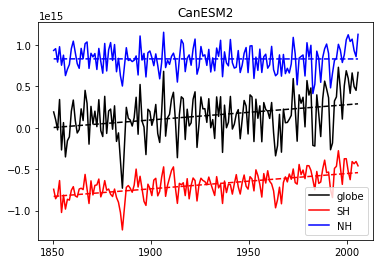

In [65]:
plot_data('CanESM2')

/g/data/r87/dbi599/DRSv2/CMIP5/CanESM2/rcp85/yr/atmos/r1i1p1/rndt/latest/dedrifted/rndt-sh-sum_Ayr_CanESM2_historical-rcp85_r1i1p1_all.nc TOA Incoming Net Radiation sh sum
/g/data/r87/dbi599/DRSv2/CMIP5/CanESM2/rcp85/yr/atmos/r1i1p1/rndt/latest/dedrifted/rndt-nh-sum_Ayr_CanESM2_historical-rcp85_r1i1p1_all.nc TOA Incoming Net Radiation nh sum
/g/data/r87/dbi599/DRSv2/CMIP5/CanESM2/rcp85/yr/atmos/r1i1p1/rndt/latest/dedrifted/rndt-globe-sum_Ayr_CanESM2_historical-rcp85_r1i1p1_all.nc TOA Incoming Net Radiation globe sum
DimCoord([2001-07-02 12:00:00], bounds=[[2001-01-01 00:00:00, 2002-01-01 00:00:00]], standard_name='time', calendar='365_day', long_name='time', var_name='time')
DimCoord([2013-07-02 12:00:00], bounds=[[2013-01-01 00:00:00, 2014-01-01 00:00:00]], standard_name='time', calendar='365_day', long_name='time', var_name='time')
y=13685237977.347523x+(-1262024414482113.750000)
y=-10662899417.887075x+(1592681019110950.250000)
y=3022270874.771498x+(330660560180146.500000)


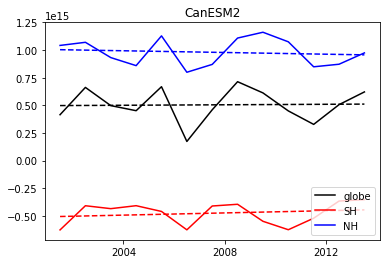

In [68]:
plot_data('CanESM2', start_time_index=151, end_time_index=164)

/g/data/r87/dbi599/DRSv2/CMIP5/CCSM4/rcp85/yr/atmos/r1i1p1/rndt/latest/dedrifted/rndt-sh-sum_Ayr_CCSM4_historical-rcp85_r1i1p1_all.nc TOA Incoming Net Radiation sh sum
/g/data/r87/dbi599/DRSv2/CMIP5/CCSM4/rcp85/yr/atmos/r1i1p1/rndt/latest/dedrifted/rndt-nh-sum_Ayr_CCSM4_historical-rcp85_r1i1p1_all.nc TOA Incoming Net Radiation nh sum
/g/data/r87/dbi599/DRSv2/CMIP5/CCSM4/rcp85/yr/atmos/r1i1p1/rndt/latest/dedrifted/rndt-globe-sum_Ayr_CCSM4_historical-rcp85_r1i1p1_all.nc TOA Incoming Net Radiation globe sum
DimCoord([1850-07-02 12:00:00], bounds=[[1850-01-01 00:00:00, 1851-01-01 00:00:00]], standard_name='time', calendar='365_day', long_name='time', var_name='time')
DimCoord([2005-07-02 12:00:00], bounds=[[2005-01-01 00:00:00, 2006-01-01 00:00:00]], standard_name='time', calendar='365_day', long_name='time', var_name='time')
y=5398076401.299723x+(-3240909216751325.000000)
y=2304088993.447057x+(-2096708352656539.750000)
y=7702160306.133201x+(-5337614009341747.000000)


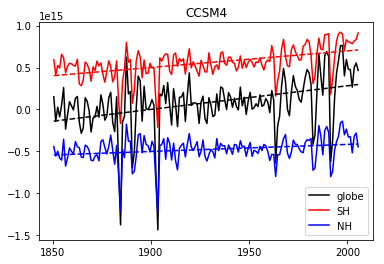

In [71]:
plot_data('CCSM4')

/g/data/r87/dbi599/DRSv2/CMIP5/CCSM4/rcp85/yr/atmos/r1i1p1/rndt/latest/dedrifted/rndt-sh-sum_Ayr_CCSM4_historical-rcp85_r1i1p1_all.nc TOA Incoming Net Radiation sh sum
/g/data/r87/dbi599/DRSv2/CMIP5/CCSM4/rcp85/yr/atmos/r1i1p1/rndt/latest/dedrifted/rndt-nh-sum_Ayr_CCSM4_historical-rcp85_r1i1p1_all.nc TOA Incoming Net Radiation nh sum
/g/data/r87/dbi599/DRSv2/CMIP5/CCSM4/rcp85/yr/atmos/r1i1p1/rndt/latest/dedrifted/rndt-globe-sum_Ayr_CCSM4_historical-rcp85_r1i1p1_all.nc TOA Incoming Net Radiation globe sum
DimCoord([2001-07-02 12:00:00], bounds=[[2001-01-01 00:00:00, 2002-01-01 00:00:00]], standard_name='time', calendar='365_day', long_name='time', var_name='time')
DimCoord([2013-07-02 12:00:00], bounds=[[2013-01-01 00:00:00, 2014-01-01 00:00:00]], standard_name='time', calendar='365_day', long_name='time', var_name='time')
y=-5403872831.247198x+(4760104703303844.000000)
y=14610006811.153255x+(-11041024433558974.000000)
y=9206216817.883606x+(-6280980496594028.000000)


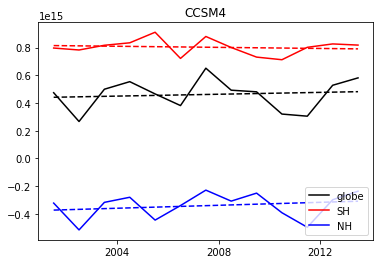

In [70]:
plot_data('CCSM4', start_time_index=151, end_time_index=164)

/g/data/r87/dbi599/DRSv2/CMIP5/CSIRO-Mk3-6-0/rcp85/yr/atmos/r1i1p1/rndt/latest/dedrifted/rndt-sh-sum_Ayr_CSIRO-Mk3-6-0_historical-rcp85_r1i1p1_all.nc TOA Incoming Net Radiation sh sum
/g/data/r87/dbi599/DRSv2/CMIP5/CSIRO-Mk3-6-0/rcp85/yr/atmos/r1i1p1/rndt/latest/dedrifted/rndt-nh-sum_Ayr_CSIRO-Mk3-6-0_historical-rcp85_r1i1p1_all.nc TOA Incoming Net Radiation nh sum
/g/data/r87/dbi599/DRSv2/CMIP5/CSIRO-Mk3-6-0/rcp85/yr/atmos/r1i1p1/rndt/latest/dedrifted/rndt-globe-sum_Ayr_CSIRO-Mk3-6-0_historical-rcp85_r1i1p1_all.nc TOA Incoming Net Radiation globe sum
DimCoord([1850-07-02 12:00:00], bounds=[[1850-01-01 00:00:00, 1851-01-01 00:00:00]], standard_name='time', calendar='365_day', long_name='time', var_name='time')
DimCoord([2005-07-02 12:00:00], bounds=[[2005-01-01 00:00:00, 2006-01-01 00:00:00]], standard_name='time', calendar='365_day', long_name='time', var_name='time')
y=2142877198.228757x+(-1784130435064818.250000)
y=-4002897854.033761x+(3249823104151779.500000)
y=-1860016237.439820x+

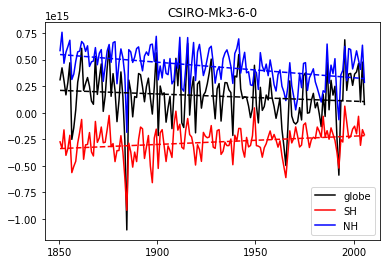

In [72]:
plot_data('CSIRO-Mk3-6-0')

/g/data/r87/dbi599/DRSv2/CMIP5/CSIRO-Mk3-6-0/rcp85/yr/atmos/r1i1p1/rndt/latest/dedrifted/rndt-sh-sum_Ayr_CSIRO-Mk3-6-0_historical-rcp85_r1i1p1_all.nc TOA Incoming Net Radiation sh sum
/g/data/r87/dbi599/DRSv2/CMIP5/CSIRO-Mk3-6-0/rcp85/yr/atmos/r1i1p1/rndt/latest/dedrifted/rndt-nh-sum_Ayr_CSIRO-Mk3-6-0_historical-rcp85_r1i1p1_all.nc TOA Incoming Net Radiation nh sum
/g/data/r87/dbi599/DRSv2/CMIP5/CSIRO-Mk3-6-0/rcp85/yr/atmos/r1i1p1/rndt/latest/dedrifted/rndt-globe-sum_Ayr_CSIRO-Mk3-6-0_historical-rcp85_r1i1p1_all.nc TOA Incoming Net Radiation globe sum
DimCoord([2001-07-02 12:00:00], bounds=[[2001-01-01 00:00:00, 2002-01-01 00:00:00]], standard_name='time', calendar='365_day', long_name='time', var_name='time')
DimCoord([2013-07-02 12:00:00], bounds=[[2013-01-01 00:00:00, 2014-01-01 00:00:00]], standard_name='time', calendar='365_day', long_name='time', var_name='time')
y=-14511044471.798166x+(10461254531049278.000000)
y=9085741102.184444x+(-6165808044251452.000000)
y=-5425305642.607043

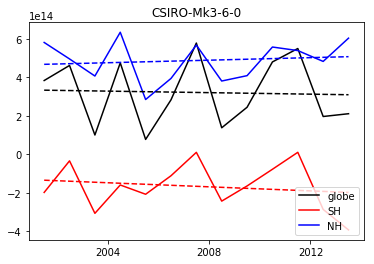

In [73]:
plot_data('CSIRO-Mk3-6-0', start_time_index=151, end_time_index=164)

/g/data/r87/dbi599/DRSv2/CMIP5/GISS-E2-R/rcp85/yr/atmos/r1i1p1/rndt/latest/dedrifted/rndt-sh-sum_Ayr_GISS-E2-R_historical-rcp85_r1i1p1_all.nc TOA Incoming Net Radiation sh sum
/g/data/r87/dbi599/DRSv2/CMIP5/GISS-E2-R/rcp85/yr/atmos/r1i1p1/rndt/latest/dedrifted/rndt-nh-sum_Ayr_GISS-E2-R_historical-rcp85_r1i1p1_all.nc TOA Incoming Net Radiation nh sum
/g/data/r87/dbi599/DRSv2/CMIP5/GISS-E2-R/rcp85/yr/atmos/r1i1p1/rndt/latest/dedrifted/rndt-globe-sum_Ayr_GISS-E2-R_historical-rcp85_r1i1p1_all.nc TOA Incoming Net Radiation globe sum
DimCoord([1850-07-02 12:00:00], bounds=[[1850-01-01 00:00:00, 1851-01-01 00:00:00]], standard_name='time', calendar='365_day', long_name='time', var_name='time')
DimCoord([2005-07-02 12:00:00], bounds=[[2005-01-01 00:00:00, 2006-01-01 00:00:00]], standard_name='time', calendar='365_day', long_name='time', var_name='time')
y=4917493568.901720x+(3912982990429718.000000)
y=2417374733.389053x+(1744464493019227.500000)
y=7334871903.195924x+(5657450252010364.000000)


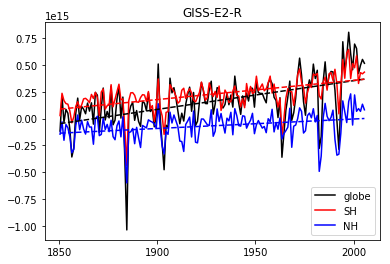

In [77]:
plot_data('GISS-E2-R') 

/g/data/r87/dbi599/DRSv2/CMIP5/GISS-E2-R/rcp85/yr/atmos/r1i1p1/rndt/latest/dedrifted/rndt-sh-sum_Ayr_GISS-E2-R_historical-rcp85_r1i1p1_all.nc TOA Incoming Net Radiation sh sum
/g/data/r87/dbi599/DRSv2/CMIP5/GISS-E2-R/rcp85/yr/atmos/r1i1p1/rndt/latest/dedrifted/rndt-nh-sum_Ayr_GISS-E2-R_historical-rcp85_r1i1p1_all.nc TOA Incoming Net Radiation nh sum
/g/data/r87/dbi599/DRSv2/CMIP5/GISS-E2-R/rcp85/yr/atmos/r1i1p1/rndt/latest/dedrifted/rndt-globe-sum_Ayr_GISS-E2-R_historical-rcp85_r1i1p1_all.nc TOA Incoming Net Radiation globe sum
DimCoord([2001-07-02 12:00:00], bounds=[[2001-01-01 00:00:00, 2002-01-01 00:00:00]], standard_name='time', calendar='365_day', long_name='time', var_name='time')
DimCoord([2013-07-02 12:00:00], bounds=[[2013-01-01 00:00:00, 2014-01-01 00:00:00]], standard_name='time', calendar='365_day', long_name='time', var_name='time')
y=-3320915926.873178x+(-1921962744531349.250000)
y=-84008569.082639x+(2791822722467.605469)
y=-3404869691.562140x+(-1919131305317047.000000)


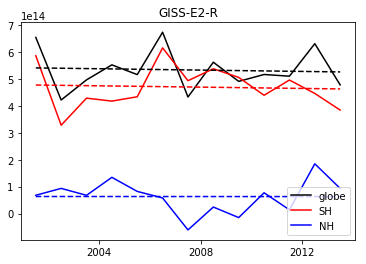

In [75]:
plot_data('GISS-E2-R', start_time_index=151, end_time_index=164)

/g/data/r87/dbi599/DRSv2/CMIP5/NorESM1-M/rcp85/yr/atmos/r1i1p1/rndt/latest/dedrifted/rndt-sh-sum_Ayr_NorESM1-M_historical-rcp85_r1i1p1_all.nc TOA Incoming Net Radiation sh sum
/g/data/r87/dbi599/DRSv2/CMIP5/NorESM1-M/rcp85/yr/atmos/r1i1p1/rndt/latest/dedrifted/rndt-nh-sum_Ayr_NorESM1-M_historical-rcp85_r1i1p1_all.nc TOA Incoming Net Radiation nh sum
/g/data/r87/dbi599/DRSv2/CMIP5/NorESM1-M/rcp85/yr/atmos/r1i1p1/rndt/latest/dedrifted/rndt-globe-sum_Ayr_NorESM1-M_historical-rcp85_r1i1p1_all.nc TOA Incoming Net Radiation globe sum
DimCoord([1850-07-02 12:00:00], bounds=[[1850-01-01 00:00:00, 1851-01-01 00:00:00]], standard_name='time', calendar='365_day', long_name='time', var_name='time')
DimCoord([2005-07-02 12:00:00], bounds=[[2005-01-01 00:00:00, 2006-01-01 00:00:00]], standard_name='time', calendar='365_day', long_name='time', var_name='time')
y=4221041082.606704x+(-2257389989968171.500000)
y=-811934730.738263x+(995177033324199.500000)
y=3409113116.103008x+(-1262217892183683.000000)


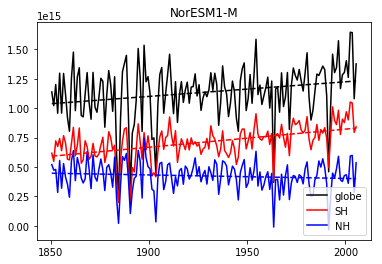

In [78]:
plot_data('NorESM1-M')

/g/data/r87/dbi599/DRSv2/CMIP5/NorESM1-M/rcp85/yr/atmos/r1i1p1/rndt/latest/dedrifted/rndt-sh-sum_Ayr_NorESM1-M_historical-rcp85_r1i1p1_all.nc TOA Incoming Net Radiation sh sum
/g/data/r87/dbi599/DRSv2/CMIP5/NorESM1-M/rcp85/yr/atmos/r1i1p1/rndt/latest/dedrifted/rndt-nh-sum_Ayr_NorESM1-M_historical-rcp85_r1i1p1_all.nc TOA Incoming Net Radiation nh sum
/g/data/r87/dbi599/DRSv2/CMIP5/NorESM1-M/rcp85/yr/atmos/r1i1p1/rndt/latest/dedrifted/rndt-globe-sum_Ayr_NorESM1-M_historical-rcp85_r1i1p1_all.nc TOA Incoming Net Radiation globe sum
DimCoord([2001-07-02 12:00:00], bounds=[[2001-01-01 00:00:00, 2002-01-01 00:00:00]], standard_name='time', calendar='365_day', long_name='time', var_name='time')
DimCoord([2013-07-02 12:00:00], bounds=[[2013-01-01 00:00:00, 2014-01-01 00:00:00]], standard_name='time', calendar='365_day', long_name='time', var_name='time')
y=210411493.610025x+(763878202138151.750000)
y=35833415886.250092x+(-25734689082824228.000000)
y=36043556641.104172x+(-24970612601647648.00000

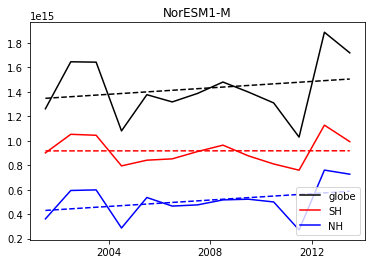

In [79]:
plot_data('NorESM1-M', start_time_index=151, end_time_index=164)

I should possibly do this for the entire CMIP5 ensemble, since I'm only looking at the historical experiment.

What are those dips and why do they happen in single forcing experiments?

Why do some of the models not start at 0 for the global value? (And should I correct that...?)


# Time constraint issues

`conda install nc-time-axis` helped with some previous issues but not this one...

In [44]:
time_constraint = get_time_constraint(['1861-01-01', '2005-12-31']) 

In [45]:
infile = '/g/data/r87/dbi599/DRSv2/CMIP5/CCSM4/historicalGHG/yr/ocean/r1i1p1/ohc/latest/dedrifted/ohc-zonal-sum_Oyr_CCSM4_historicalGHG_r1i1p1_all.nc'

In [46]:
test = iris.load_cube(infile, 'ocean heat content')

In [47]:
test.extract(time_constraint)

TypeError: cannot compare cftime.DatetimeNoLeap(1861, 7, 2, 12, 0, 0, 0, 1, 183) and PartialDateTime(year=2005, month=12, day=31)